In [2]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers import BartForConditionalGeneration, AutoTokenizer
import copy
import matplotlib.pylab as plt

In [3]:
model_checkpoint = "sshleifer/distilbart-cnn-6-6"
batch_size = 2
epochs = 4

In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Thu Mar 17 14:11:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   32C    P0    39W / 250W |   7581MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      Off  | 00000000:41:00.0 Off |                    0 |
| N/A   

In [6]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=4)

In [7]:
# define the function
def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
    """
    Shift input ids one token to the right.
    """
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

    return shifted_input_ids


# define the class
class MLT(nn.Module):
    
    def __init__(self, model_checkpoint):
      super(MLT, self).__init__()

      self.model = BartForConditionalGeneration.from_pretrained(model_checkpoint)
      self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

      self.encoder = self.model.get_encoder()

      self.decoder1 = self.model.get_decoder()
      self.decoder2 = copy.deepcopy(self.decoder1)

      self.lm_head1 = self.model.get_output_embeddings()
      self.lm_head2 = copy.deepcopy(self.lm_head1)

    def get_config(self):
      return self.model.config

    def get_decoder(self):
      return self.decoder1

    def get_lm_head(self):
      return self.lm_head1

    def get_final_logits_bias(self):
      return self.model.final_logits_bias

    def get_tokenizer(self):
      return self.tokenizer

    def forward(self, text, summary1, summary2):
      # inputs = self.tokenizer.encode(text, return_tensors="pt")
      # target1 = self.tokenizer.encode(summary1, return_tensors="pt")
      # target2 = self.tokenizer.encode(summary2, return_tensors="pt")

      inputs = text
      target1 = summary1
      target2 = summary2

      encoder_outputs = self.encoder(inputs)

      decoder_input_ids1 = shift_tokens_right(
                    target1, self.model.config.pad_token_id, self.model.config.decoder_start_token_id
                )
      
      decoder_input_ids2 = shift_tokens_right(
                    target2, self.model.config.pad_token_id, self.model.config.decoder_start_token_id
                )
      
      
      decoder_outputs1 = self.decoder1(
          decoder_input_ids1, 
          encoder_hidden_states=encoder_outputs[0], 
          use_cache = False,
          output_attentions=self.model.config.output_attentions,
          output_hidden_states=self.model.config.output_hidden_states,
          return_dict=self.model.config.use_return_dict,
          ) 

      decoder_outputs2 = self.decoder2(
          decoder_input_ids2, 
          encoder_hidden_states=encoder_outputs[0], 
          use_cache = False,
          output_attentions=self.model.config.output_attentions,
          output_hidden_states=self.model.config.output_hidden_states,
          return_dict=self.model.config.use_return_dict,
          )  

      lm_logits1 = self.lm_head1(decoder_outputs1[0]) + self.model.final_logits_bias
      lm_logits2 = self.lm_head2(decoder_outputs2[0]) + self.model.final_logits_bias   

      masked_lm_loss1 = None
      masked_lm_loss2 = None
      loss_fct = CrossEntropyLoss()
      masked_lm_loss1 = loss_fct(lm_logits1.view(-1, self.model.config.vocab_size), target1.view(-1))
      masked_lm_loss2 = loss_fct(lm_logits2.view(-1, self.model.config.vocab_size), target2.view(-1))
      
      # return {
      #     'loss1': masked_lm_loss1, 
      #     'loss2': masked_lm_loss2,
      #     'encoder_outputs': encoder_outputs
      #     }

      return (masked_lm_loss1, masked_lm_loss2, encoder_outputs)


# create the object
model = MLT(model_checkpoint)

In [8]:
model.to(device)

MLT(
  (model): BartForConditionalGeneration(
    (model): BartModel(
      (shared): Embedding(50264, 1024, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): Embedding(50264, 1024, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
        (layers): ModuleList(
          (0): BartEncoderLayer(
            (self_attn): BartAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (final_layer_norm): LayerNor

In [9]:
from pathlib import Path

transcripts_dir = Path("./data/ami/transcripts")
abs_summaries_dir = Path("./data/ami/summaries/abstractive")
ext_summaries_dir = Path("./data/ami/summaries/extractive")

transcripts = []
abs_summaries = []
ext_summaries = []

for file in transcripts_dir.iterdir():
  transcripts.append(file.read_text())

for file in abs_summaries_dir.iterdir():
  abs_summaries.append(file.read_text())

for file in ext_summaries_dir.iterdir():
  ext_summaries.append(file.read_text())

print(len(transcripts))
print(len(abs_summaries))
print(len(ext_summaries))

137
137
137


In [10]:
from sklearn.model_selection import train_test_split

train_transcripts, val_transcripts, train_abs_summaries, val_abs_summaries = train_test_split(transcripts, abs_summaries, test_size=.2)
_, _, train_ext_summaries, val_ext_summaries = train_test_split(transcripts, ext_summaries, test_size=.2)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_transcripts_encodings = tokenizer(train_transcripts, truncation=True, padding=True)
val_transcripts_encodings = tokenizer(val_transcripts, truncation=True, padding=True)

with tokenizer.as_target_tokenizer():
  train_abs_summaries_encodings = tokenizer(train_abs_summaries, truncation=True, padding=True)
  val_abs_summaries_encodings = tokenizer(val_abs_summaries, truncation=True, padding=True)

  train_ext_summaries_encodings = tokenizer(train_ext_summaries, truncation=True, padding=True)
  val_ext_summaries_encodings = tokenizer(val_ext_summaries, truncation=True, padding=True)

In [12]:
class MeetDataset(torch.utils.data.Dataset):
    def __init__(self, transcripts, abs_summaries, ext_summaries):
        self.transcripts = transcripts
        self.abs_summaries = abs_summaries
        self.ext_summaries = ext_summaries

    def __len__(self):
        return len(self.transcripts.input_ids)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.transcripts.items()}
        item["abs"] = torch.tensor(self.abs_summaries["input_ids"][idx])
        item["ext"] = torch.tensor(self.ext_summaries["input_ids"][idx])
        return item

    

train_dataset = MeetDataset(train_transcripts_encodings, train_abs_summaries_encodings, train_ext_summaries_encodings)
val_dataset = MeetDataset(val_transcripts_encodings, val_abs_summaries_encodings, val_ext_summaries_encodings)

In [13]:
train_dataset.__len__(), val_dataset.__len__()

(109, 28)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
from transformers import BartPretrainedModel
from transformers.modeling_outputs import Seq2SeqLMOutput

class DecoderForGeneration(BartPretrainedModel):

    def __init__(self, config, decoder, lm_head, final_logits_bias):
        super().__init__(config)
        
        self.config = config
        self.decoder = decoder
        self.lm_head = lm_head
        self.final_logits_bias = final_logits_bias

    # def get_encoder(self):
    #     return self.get_encoder()

    def get_decoder(self):
        return self.model.get_decoder()

    def resize_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        new_embeddings = super().resize_token_embeddings(new_num_tokens)
        self._resize_final_logits_bias(new_num_tokens)
        return new_embeddings

    def _resize_final_logits_bias(self, new_num_tokens: int) -> None:
        old_num_tokens = self.final_logits_bias.shape[-1]
        if new_num_tokens <= old_num_tokens:
            new_bias = self.final_logits_bias[:, :new_num_tokens]
        else:
            extra_bias = torch.zeros((1, new_num_tokens - old_num_tokens), device=self.final_logits_bias.device)
            new_bias = torch.cat([self.final_logits_bias, extra_bias], dim=1)
        self.register_buffer("final_logits_bias", new_bias)

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
            config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
            (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            # if use_cache:
            #     logger.warning("The `use_cache` argument is changed to `False` since `labels` is provided.")
            use_cache = False
            if decoder_input_ids is None and decoder_inputs_embeds is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id, self.config.decoder_start_token_id
                )

        decoder_outputs = self.decoder(
        decoder_input_ids, 
        encoder_hidden_states=encoder_outputs[0], 
        use_cache = False,
        output_attentions=self.config.output_attentions,
        output_hidden_states=self.config.output_hidden_states,
        return_dict=self.config.use_return_dict,
        )
        lm_logits = self.lm_head(decoder_outputs[0]) + self.final_logits_bias

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(lm_logits.view(-1, model.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + decoder_outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

    def prepare_inputs_for_generation(
        self,
        decoder_input_ids,
        past=None,
        attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        use_cache=None,
        encoder_outputs=None,
        **kwargs
    ):
        # cut decoder_input_ids if past is used
        if past is not None:
            decoder_input_ids = decoder_input_ids[:, -1:]

        return {
            "input_ids": None,  # encoder_outputs is defined. input_ids not needed
            "encoder_outputs": encoder_outputs,
            "past_key_values": past,
            "decoder_input_ids": decoder_input_ids,
            "attention_mask": attention_mask,
            "head_mask": head_mask,
            "decoder_head_mask": decoder_head_mask,
            "cross_attn_head_mask": cross_attn_head_mask,
            "use_cache": use_cache,  # change this to avoid caching (presumably for debugging)
        }

    def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
        return shift_tokens_right(labels, self.config.pad_token_id, self.config.decoder_start_token_id)

    @staticmethod
    def _reorder_cache(past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            # cached cross_attention states don't have to be reordered -> they are always the same
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx) for past_state in layer_past[:2]) + layer_past[2:],
            )
        return reordered_past


myDecoderModel = DecoderForGeneration(model.get_config(), model.get_decoder(), model.get_lm_head(), model.get_final_logits_bias())

In [16]:
myDecoderModel.to(device)

DecoderForGeneration(
  (decoder): BartDecoder(
    (embed_tokens): Embedding(50264, 1024, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
    (layers): ModuleList(
      (0): BartDecoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder_attn): BartAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=Tru

In [17]:
from datasets import load_metric

metric = load_metric("rouge")

In [18]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
import numpy as np
import nltk
nltk.download('punkt')
def train(model, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_loss': []}  
    
    for epoch in range(epochs):
        print(epoch)
        # model.train()
        for i, data in enumerate(train_loader):
            data['input_ids'], data['abs'], data['ext'] = data['input_ids'].to(device), data['abs'].to(device), data['ext'].to(device)
            optimizer.zero_grad()
            output = model(data['input_ids'], data['abs'], data['ext'])
            loss = output[0] + output[1]
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.item())
            print(loss.item())

        print("Validation")
        model.eval()
        for i, data in enumerate(validation_loader):
            with torch.no_grad():
              data['input_ids'], data['abs'], data['ext'] = data['input_ids'].to(device), data['abs'].to(device), data['ext'].to(device)
              output = model(data['input_ids'], data['abs'], data['ext'])
              loss = output[0] + output[1]
              useful_stuff['validation_loss'].append(loss.item())
              print(loss.item())

              predictions = myDecoderModel.generate(data['input_ids'], encoder_outputs=output[2])
              labels = data['abs'].cpu()

              decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
              print(decoded_preds)
              # Replace -100 in the labels as we can't decode them.
              labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
              decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
              
              # Rouge expects a newline after each sentence
              decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
              decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

              metric.add_batch(predictions=decoded_preds, references=decoded_labels)
              
        result = metric.compute(use_stemmer=True)
        # Extract a few results from ROUGE
        result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

        result = {k: round(v, 4) for k, v in result.items()}
    
    return (useful_stuff, result)

training_results = train(model, train_loader, validation_loader, optimizer, epochs=epochs)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/tanik_1821cs08/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0
19.73227310180664
19.418498992919922
12.108306884765625
7.194122314453125
7.317293643951416
7.557563304901123
7.494473457336426
6.816224575042725
6.439085483551025
5.52711296081543
5.905647277832031
6.435910701751709
6.1164045333862305
5.465237617492676
6.205121040344238
5.894718170166016
6.3509674072265625
5.904469013214111
5.566380500793457
5.455780982971191
5.729231357574463
5.89748477935791
5.454373836517334
5.871809959411621
5.468691825866699
5.8247904777526855
6.305272102355957
4.43688440322876
5.328738212585449
5.792892932891846
5.674355506896973
4.764590263366699
6.088944911956787
5.3227691650390625
4.881150722503662
5.867395401000977
5.5407185554504395
5.542469024658203
5.8657121658325195
6.350381851196289
5.288341999053955
5.943982124328613
5.467641830444336
5.292670726776123
5.664393424987793
5.873584270477295
5.403336524963379
5.659421920776367
5.651583194732666
5.38958215713501
5.35093355178833
5.753055095672607
5.002080917358398
4.749129295349121
5.253541946411133
Valid

["The Industrial Designer is the Industrial Designer for the project. The Industrial Designer will be responsible for the design of the remote control. The Marketing Expert is the Marketing Expert. He will discuss the project's marketing strategy and the product design. He'll also discuss the design and marketing requirements for the remote remote. The Project Manager will also discuss how the remote will be used to control the remote, and how to use the remote. He has the idea of using a remote to find out if the remote can be used for a remote, but the remote is always missing. The User Interface Designer will discuss how to make a remote that can be controlled by a remote control device. The project manager will", "The remote is based on anti-theft technology. It's based on the anti- theft technology for suitcases. The remote is designed to be easy to use and easy to put on the back of the remote. The colour of the device is not a special colour, but it's not special. The company ha

['The Project Manager and the Project Manager. The Project Manager discussed the idea of combining plastic and rubber with rubber and rubber. The project manager and the project manager discussed the design of the project. The team discussed the possibility of combining the materials and materials to create the product. The product designer discussed the need to have the on-off button on the front of the case. The group discussed how they would like to use the case to make the case look like a banana. The marketing expert discussed how to make a case and how to use a rubber case. They discussed the cost of the components and how they should be used in the design. They also discussed the feasibility of using special materials', 'The Marketing Manager and the Marketing Manager are meeting to discuss the needs and desires of the group. The Marketing Manager is meeting with the group to discuss what they want to do with the project. The group also discussed the need for a full screen. The 

["The marketing expert gave a presentation of the meeting's agenda. The marketing expert presented the group's agenda for the meeting. The group then discussed the future of the remote control. They discussed the possibility of using the remote to communicate with each other. They also discussed how to use the remote and how to make the remote easier to use. The team then discussed how they would like to incorporate the remote into their marketing strategy. They decided that the remote should be used in the marketing tool. They then decided that they should not use the remotes to communicate and that it would not be too expensive to do so. They were also considering using a remote control for the remote.    and that", 'The project manager and the project manager presented the project to the group. The marketing expert presented the product to the team and the marketing expert. The industrial designer presented the prototype of the device. The group then discussed the marketing strategy

['The Project Manager and the Project Manager opened the meeting to discuss the project. The Project Manager introduced the project manager to the group and the group discussed their ideas for a remote control. The group then discussed the features of the remote, the menu, and the user interface, and how to use the remote. The project manager then opened the project to discuss their ideas. The team then discussed their plans for the project and discussed the product design. The marketing expert suggested that the remote should be more user-friendly, and that the group should be able to use it as a remote. They also discussed the possibility of using the remote control to make it easier to navigate and to make the device easier', 'The project manager opened the meeting and opened the agenda. The project manager introduced the project manager to the project management. The marketing expert opened the presentation and discussed the project budget. The group then discussed the marketing st

4.307267189025879
5.205278396606445
4.004432201385498
5.1547393798828125
5.316719055175781
4.730057716369629
5.148975372314453
4.990431785583496
Validation
6.210080146789551
['The Project Manager and the Project Manager opened the meeting. The Project Manager introduced the project manager and the group discussed the project budget for the project. The group discussed how to make the project look like a remote. The marketing expert presented the project to the group and the team members. The project manager presented the prototype of the project and discussed the need for a remote control. The team members discussed the possibility of using a remote to control the remote. They discussed the idea of using an LCD screen to make it look like it would be easy to control a remote, but the group decided not to use the LCD screen because of the cost of the device. They decided to use a LCD screen', 'The project manager opened the meeting and opened a meeting with the group members. The group 

['The Project Manager and the Project Manager presented the project to the group. The Project Manager opened the meeting and discussed the requirements of the project. The Industrial Designer presented a prototype of a remote control that could be used to control the remote. The Marketing Expert presented the prototype of the remote, which was designed by the Industrial Designer. The User Interface Designer presented the remote control design. The group discussed the prototype design, and the project manager gave the group a prototype design for the device. The project manager presented the product to the team and the group members. The marketing expert presented the final prototype design and the user interface design. ', 'The remote is based on anti-theft technology. The remote is designed to be easy to use and easy to control with a remote. It will be difficult to control the remote because of the size of the device. It would be too expensive to add a remote to the remote, and it wi

['The Project Manager and the Project Manager opened the meeting. The Project Manager introduced the project to the group members. The Marketing Expert presented the project manager and the Marketing Expert. The Industrial Designer presented the prototype of the project. The group discussed the idea of using rubber and rubber to make the device. The marketing expert presented the product to the marketing expert. The project manager discussed the need for an LCD screen. The team discussed the possibility of using a rubber case. The industrial designer suggested that the prototype could be used to make a case for the remote, but the group decided not to use it. The prototype was designed to be easy to use, but it would be difficult to use.', "The Marketing Manager and the Marketing Manager presented the group's agenda. The Marketing Manager opened the meeting and presented the agenda. He presented the budget for the project. The group then discussed the project budget, and the budget. Th

['The project manager opened the meeting to discuss the project. The project manager introduced the project to the group. The group then discussed the project budget for the project and the overall cost of the product. The marketing expert gave a presentation on the project, the project manager and the group members, the marketing expert, and the team members. The team members discussed the role of the project leader, the group member, the team member, and their personal preferences, the user interface, the product designer, the manufacturer, the cost of their product, the materials and the marketing specialist, the industrial designer, and they discussed the product design. They discussed the possibility of using a rubber case to make the device more', 'The project manager opened the meeting by saying that the project manager will introduce the project to the group. The project manager introduced the project management team to the team members. The group then discussed the project bud

6.504709243774414
["The project manager opened the meeting. The project manager presented the project to the group members. The group then discussed the project budget and the project costs. The marketing expert presented the results of the project and presented the findings of the group's findings. The team then discussed their findings on the project. They then discussed how to make the project look like they would like to make it easier to use. They also discussed the possibility of using an LCD screen, and how to use a rubber casing. They discussed the cost of the device, which they decided would be too expensive. They concluded that the project should be completed by the end of the meeting, and that the team should decide whether to use the", 'The project manager opened the meeting and discussed the project budget for the project. The project manager presented the project to the team and the team members. The marketing expert discussed the role of the project manager in the market

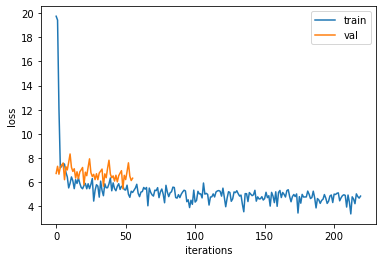

In [20]:
plt.plot(training_results[0]['training_loss'], label="train")
plt.plot(training_results[0]['validation_loss'], label="val")
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
#plt.title('training loss iterations')

In [21]:
training_results[1]

{'rouge1': 41.775, 'rouge2': 14.303, 'rougeL': 25.0082, 'rougeLsum': 39.5555}

In [ ]:
!nvidia-smi